<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

 <font size="6"><p style="text-align:center"><b> Постройка модели для прогноза оттока клиентов банка "Бета-банк" </b></p></font>

<div class="alert alert-dan
            ger">
<font size="4"><b>План:</b></font>
    <br /> 
    <font size="3", color = "black">
<br />

- В нашем распоряжении данные о поведении клиентов, которые уже расторгли договор с банком.  
        
- Обработаем данные и построим модель, которая даст прогноз о возможном уходе клиента. ROC-AUC не менее 0.85.
        
- Это позволит сделать ставку на сохранение старых клиентов.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

<font size="5"><p style="text-align:center"><b> ***Шаг 1. Обзор и предобработка данных*** </b></p></font>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,6)
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, f1_score

!pip install -U imbalanced-learn --user
!pip install -q imbalanced-learn
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 1703

In [2]:
try:
    data = pd.read_csv('C:/Users/Asus/Downloads/Churn.csv')
except:
    data = pd.read_csv('/datasets/Churn.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В столбце tenure есть пропуски - видимо, те люди, у которых срок пользования услугами банка менее года. 
Три столбца: фамилия, страна, пол - имеют объектный тип, поэтому их нужно изменить на количественный методом OHE для работы модели. При этом возникнет огромное количество столбцов с разными фамилиями. Условимся, что фамилия едва ли влияет на отказ от услуг банка, и удалим этот столбец, как и столбцы с номером строки и id.

Посмотрим, как данные выглядят в таблице.

In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Изменим названия столбцов на стандартные - нижний регистр.

In [6]:
data.columns = data.columns.str.lower()

Удалим столбцы с фамилиями, номером строки, id. 

In [7]:
data.drop(['surname', 'rownumber', 'customerid'], axis = 1, inplace=True)

Так как пропусков в столбце tenure более 9%, и, вероятно, это те люди, у которых срок пользования услугами банка менее года, то не будем их удалять, заменим на константу.

In [8]:
data['tenure'].fillna('0', inplace=True)
data['tenure'] = data['tenure'].astype('int')

<font size="5"><p style="text-align:center"><b> ***Шаг 2. Исследование модели*** </b></p></font>

Исследуем дисбаланс классов.

0    0.7963
1    0.2037
Name: exited, dtype: float64


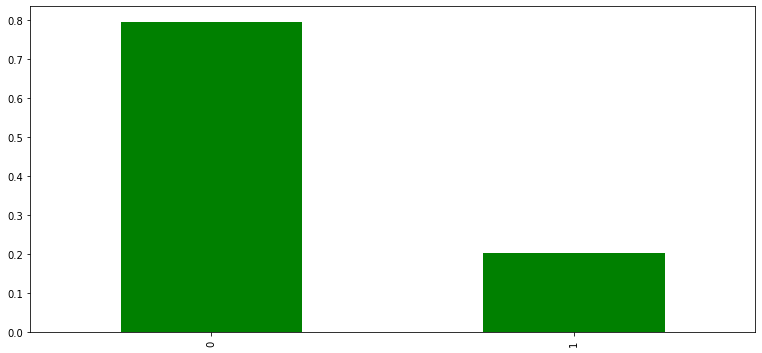

In [9]:
class_frequency = data['exited'].value_counts(normalize=data.shape)
print(class_frequency)
class_frequency.plot(kind='bar', color = 'green');

Ушедших клиентов почти в 4 раза меньше оставшихся - дисбаланс классов есть.

In [10]:
# отделим признаки от таргета
target = data['exited']
features = data.drop('exited', axis=1)

Разделим датасет на две выборки в соотношении 3:1.

In [11]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.25, 
                                                                            random_state=RANDOM_STATE)

Проверим размерность.

In [12]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(7500, 10)
(7500,)
(2500, 10)
(2500,)


In [13]:
features_object = features_train.select_dtypes(include='object').columns.to_list()

In [14]:
numeric = ['creditscore', 'tenure', 'balance', 'age', 'numofproducts', 'estimatedsalary', 'isactivemember', 'hascrcard']

In [15]:
col_transformer = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'),
        features_object),
    (StandardScaler(), 
        numeric),
    remainder='passthrough',
    verbose_feature_names_out=False)

Отберём необходимые признаки для большей генерализации модели.

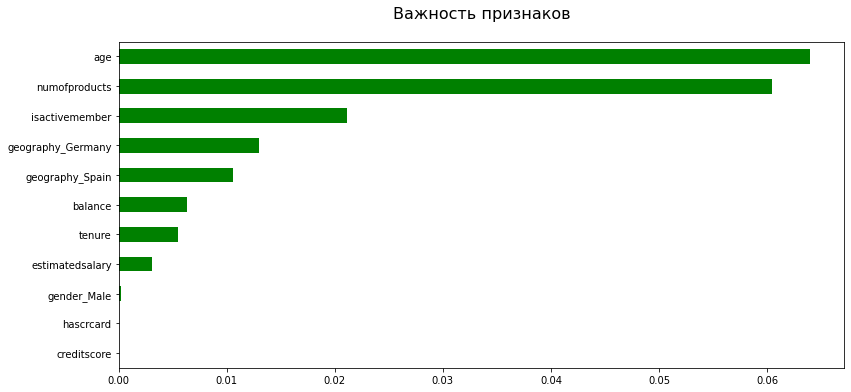

In [16]:
features = pd.DataFrame(col_transformer.fit_transform(features_train),
    columns=col_transformer.get_feature_names_out())
X = features
y = target_train
importances = mutual_info_classif(X=X, y=y) 
feature_importances = pd.Series(importances, X.columns).sort_values()
feature_importances.plot(kind='barh', color='green').set_title('Важность признаков' + "\n", fontsize = 16)
plt.show;

Большее значение на таргет имеют возраст и количество продуктов банка. Так как столбцов не так много, не будем удалять иные, имеющие малое значение на оси абсцисс.

Обучим модель логистической регрессии.

In [19]:
model_lr = LogisticRegression(random_state=42)
pipline_lr = make_pipeline(col_transformer, model_lr)

param_grid_lr = {'logisticregression__C':[0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 500, 1000]}

metrics = ['f1', 'roc_auc']

# для экономии времени будем использовать RandomizedSearchCV
search_lr = RandomizedSearchCV(pipline_lr, param_grid_lr, cv=4, scoring=metrics, refit='roc_auc', random_state=RANDOM_STATE)
search_lr.fit(features_train, target_train)
results_lr = search_lr.cv_results_

print('AUC-ROC on VALID:', '%.4f' %search_lr.best_score_)
print('F1 on VALID:', '%.4f' %results_lr['mean_test_f1'].mean())
print(pd.Series(search_lr.best_params_))

AUC-ROC on VALID: 0.7587
F1 on VALID: 0.2635
logisticregression__C    0.1
dtype: float64


Случайный лес.

In [20]:
model_rf = RandomForestClassifier(random_state=96)
pipline_rf = make_pipeline(col_transformer, model_rf)

parameters = {
    'randomforestclassifier__n_estimators': range(50, 121, 5),
    'randomforestclassifier__max_depth': range(2, 11),
    'randomforestclassifier__min_samples_leaf': range(1, 4),
}

metrics = ['f1', 'roc_auc']

search_rf = RandomizedSearchCV(pipline_rf, parameters, cv=4, scoring=metrics, refit='roc_auc', random_state=RANDOM_STATE)
search_rf.fit(features_train, target_train)
results_rf = search_rf.cv_results_

print('AUC-ROC on VALID:', '%.4f' %search_rf.best_score_)
print('F1 on VALID:', '%.4f' %results_rf['mean_test_f1'].mean())
print(pd.Series(search_rf.best_params_))

AUC-ROC on VALID: 0.8547
F1 on VALID: 0.4962
randomforestclassifier__n_estimators        90
randomforestclassifier__min_samples_leaf     2
randomforestclassifier__max_depth           10
dtype: int64


Градиентный бустинг.

In [21]:
model_gb = GradientBoostingClassifier(random_state=96)
pipline_gb = make_pipeline(col_transformer, model_gb)

param_grid_gb = {
    'gradientboostingclassifier__n_estimators': range(50, 251, 50),
    'gradientboostingclassifier__max_depth': range(2, 15),
    'gradientboostingclassifier__min_samples_split': (2, 3, 4),
    'gradientboostingclassifier__min_samples_leaf': (1, 2, 3, 4)
}

metrics = ['f1', 'roc_auc']

gs_gb = RandomizedSearchCV(
    pipline_gb, 
    param_distributions=param_grid_gb, 
    scoring=metrics,
    refit='roc_auc',
    n_jobs=-1, 
    verbose=10,
    error_score='raise',
    cv = 4,
    random_state=RANDOM_STATE)

gs_gb.fit(features_train, target_train)
results_gb = gs_gb.cv_results_

print('AUC-ROC on VALID:', '%.4f' %gs_gb.best_score_)
print('F1 on VALID:', '%.4f' %results_gb['mean_test_f1'].mean())
print(pd.Series(gs_gb.best_params_))

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4; 1/10] START gradientboostingclassifier__max_depth=6, gradientboostingclassifier__min_samples_leaf=1, gradientboostingclassifier__min_samples_split=2, gradientboostingclassifier__n_estimators=150
[CV 1/4; 1/10] END gradientboostingclassifier__max_depth=6, gradientboostingclassifier__min_samples_leaf=1, gradientboostingclassifier__min_samples_split=2, gradientboostingclassifier__n_estimators=150; f1: (test=0.604) roc_auc: (test=0.855) total time=   5.0s
[CV 2/4; 1/10] START gradientboostingclassifier__max_depth=6, gradientboostingclassifier__min_samples_leaf=1, gradientboostingclassifier__min_samples_split=2, gradientboostingclassifier__n_estimators=150
[CV 2/4; 1/10] END gradientboostingclassifier__max_depth=6, gradientboostingclassifier__min_samples_leaf=1, gradientboostingclassifier__min_samples_split=2, gradientboostingclassifier__n_estimators=150; f1: (test=0.564) roc_auc: (test=0.840) total time=   5.0s
[CV 3/4; 

In [22]:
metrics = {'Metrics': ['ROC-AUC', 'F1-мера'],
           'LogisticRegression': ['%.5f' %search_lr.best_score_, '%.4f' %results_lr['mean_test_f1'].mean()],
           'RandomForestClassifier': ['%.5f' %search_rf.best_score_, '%.4f' %results_rf['mean_test_f1'].mean()],
           'GradientBoostingClassifier': ['%.5f' %gs_gb.best_score_, '%.4f' %results_gb['mean_test_f1'].mean()]
        }
metrics_final = pd.DataFrame(data=metrics)
metrics_final

,Metrics,LogisticRegression,RandomForestClassifier,GradientBoostingClassifier
0,ROC-AUC,0.75875,0.85471,0.85544
1,F1-мера,0.2635,0.4962,0.5632


*Вывод по обучению модели: лучшая F1-мера и площадь AUC-ROC у градиентного бустинга.*

<font size="5"><p style="text-align:center"><b> ***Шаг 4. Тестирование*** </b></p></font>

Тестируем модель градиентный бустинг.

In [23]:
features_train = pd.DataFrame(col_transformer.fit_transform(features_train),
    columns=col_transformer.get_feature_names_out())

features_test = pd.DataFrame(col_transformer.fit_transform(features_test),
    columns=col_transformer.get_feature_names_out())

In [24]:
gb = GradientBoostingClassifier(random_state=96, learning_rate=0.1, n_estimators=150, max_depth=3,\
                               min_samples_split=3, min_samples_leaf=3)
gb.fit(features_train, target_train)
predictions = gb.predict(features_test)

print('F1:', f1_score(target_test, predictions))

probabilities_test = gb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print('ROC-AUC:', roc_auc_score(target_test, probabilities_one_test))

F1: 0.5965770171149144
ROC-AUC: 0.8816872037730307


Проверим модель на вменяемость.

In [25]:
print('ROC-AUC:', roc_auc_score(target_test, probabilities_one_test))

ROC-AUC: 0.8816872037730307


In [26]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=1)
dummy_clf.fit(features_train, target_train)
probabilities_test = dummy_clf.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print('ROC-AUC:', roc_auc_score(target_test, probabilities_one_test))

ROC-AUC: 0.5


Модель адекватна.

<font size="5"><p style="text-align:center"><b> ***Вывод*** </b></p></font>

1. Мы выполнили обзор данных: таблицы со сведениями о поведении клиентов банка. Устранили неинформативные признаки, применили прямое кодирование объектных признаков, масштабирование числовых небинарных признаков. Разделили данные на обучающую и тестовую выборки.

2. Выявили дисбаланс классов. Создали несколько моделей для задачи классификации, выявили оптимальные гиперпараметры,  обнаружили, что лучшие F1-мера и ROC-AUC у градиентного бустинга.

3. При тестировании модели на тестовой выборке добились значения 0.88 для ROC-AUC и 0.6 для F1-меры.

4. Проверили нашу модель на вменяемость.

Лучшей моделью для подбора тарифа для прогноза оттока клиентов банка "Бета-банк" является градиентный бустинг.